# Week 8: Support Vector Machines



In [3]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mat = pd.read_csv('WBC.csv')

#Drop the unnamed first column
mat.drop('Unnamed: 0', axis=1, inplace=True)

#### (1) Choose any two variables and plot them against cell identity (in color). Do you see clear separation of these classes? What does this tell you about whether or not you can classify the cells if differing type?

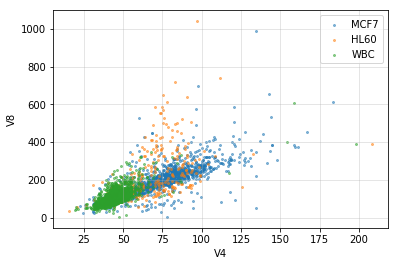

In [4]:
# Drop the column containing cell type
celldata = mat.drop('Sample', axis = 1)

# Get the cell types as strings
celltypes = set(mat['Sample'])

WBC_bool = (mat.Sample == 'WBC')
MCF7_bool = (mat.Sample == 'MCF7')
HL60_bool = (mat.Sample == 'HL60')

# Convert from T/F to 1/0
WBC_indx = WBC_bool.astype(int)
MCF7_indx = MCF7_bool.astype(int)
HL60_indx = HL60_bool.astype(int)

for i in list(celltypes):#[WBC_bool, MCF7_bool, HL60_bool]:
    celltypeindex = mat['Sample'] == i
    plt.scatter(mat.loc[celltypeindex,'V4'],mat.loc[celltypeindex,'V8'], s=4, alpha = 0.5)

plt.grid(alpha=0.4)
plt.xlabel('V4')
plt.ylabel('V8')
plt.legend(list(celltypes))
plt.show()

This graph plotting the cells by the randomly selected variables V4 and V8 does not separate the cell types very effectively. While there is some division by color, they are overlapping far too much for us to classify the cells by differing types. 

#### (3) Use principal components analysis to visualize the variation in each variable. Plot the first two principal components against the cell type. Do you see better separation in this case? What does this tell you about your ability to distinguish the cell types?

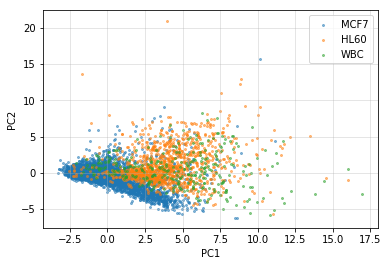

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# Define pca 
pca = PCA()

# Convert to matrix
x_data = celldata.as_matrix()

# Normalize the data
x_datascale = scale(x_data)

x_PCs = pca.fit_transform(x_datascale)

for i in [WBC_bool, MCF7_bool, HL60_bool]:
    plt.scatter(x_PCs[i,0],x_PCs[i,1], s=4, alpha = 0.5)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(alpha = 0.4)
plt.legend(list(celltypes));

Graphing the cells along PC1 and PC2 does  provide better separation than we saw in our first graph. However, there is still a significant amount of overlap between the cancerous MCF7s and the non-cancerous WBCs. This means that it will still be moderately challenging to distinguish between cell types. 

#### (4) How does partial least squares fare in desciminating cancer and non-cancer cells (make cancer=1 and non-cancer=0; this is called PLS-DA)? How does this relate to the results in the previous questions?

In [7]:
#Assign number of princle components and maximum iterations
from sklearn.cross_decomposition import PLSRegression
PLS = PLSRegression(n_components = 5, scale=True, max_iter =1000) 

#Create index for cancer versus non-cancer cells
cancer = MCF7_indx + HL60_indx

# Learn and apply the dimension reduction on the training data
xS, yS = PLS.fit_transform(x_datascale,cancer)

# Score X and Y48
score = PLS.score(x_datascale,cancer)
print('Score value =', score)

Score value = 0.689301130624


#### (5) Setup a support vector machine classifier (with linear kernel) to distinguish cancer and non-cancer.

Evaluate how well this performs (hint: think carefully about how you evaluate the model).

In [8]:
from sklearn.svm import SVC 
from sklearn.model_selection import LeaveOneOut
svc_lin = SVC(kernel='linear', C=1)
loo = LeaveOneOut()

#Convert cancer idndex from dataframe to matrix
cancer_mat = cancer.as_matrix

#Select random 1000 cells
randMask = np.random.choice(10107,1000,replace = False)
X_temp = x_datascale[randMask]
Y_temp = cancer_mat(randMask)

Yloo_lin = np.zeros((1000,1)) #Initialize array for loo scores

#Fit model for 1000 selected cells 
svc_lin.fit(X_temp, Y_temp)

#Evaluate model performance using leave-one-out cross-validation
for train_index, test_index in loo.split(X_temp):   
    svc_lin.fit(X_temp[train_index], Y_temp[train_index])    
    Yloo_lin[test_index] = svc_lin.score(X_temp[test_index],Y_temp[test_index])
avg_score_lin = np.mean(Yloo_lin)
print('Score value =', avg_score_lin)

Score value = 0.971


#### (6) Choose and justify your selection of a different kernel to use in SVM classification. (Hint: It should be a kernel with varying complexity, such as polynomial or RBF.)

In [28]:
# Select poly kernel type
svc_poly = SVC(kernel='poly',C=1)
svc_rbf = SVC(kernel='rbf',C=1)
svc_sig = SVC(kernel='sigmoid',C=1)

# Initiliaze leave-one-out scores
Yloo_poly = np.zeros((1000,1))
Yloo_rbf = np.zeros((1000,1))
Yloo_sig = np.zeros((1000,1))

# Evaluate model performances using leave-one-out cross-validation
for train_index, test_index in loo.split(X_temp):  
    ## polynomial kernel
    svc_poly.fit(X_temp[train_index], Y_temp[train_index])    
    Yloo_poly[test_index] = svc_poly.score(X_temp[test_index],Y_temp[test_index])
    ## RBF kernel
    svc_rbf.fit(X_temp[train_index], Y_temp[train_index])    
    Yloo_rbf[test_index] = svc_rbf.score(X_temp[test_index],Y_temp[test_index])
    ## sigmoid kernel
    svc_sig.fit(X_temp[train_index], Y_temp[train_index])    
    Yloo_sig[test_index] = svc_sig.score(X_temp[test_index],Y_temp[test_index])

# Print average score
## polynomial kernel
avg_score_poly = np.mean(Yloo_poly)
print('Poly kernel average score =', avg_score_poly)
## RBF kernel
avg_score_rbf = np.mean(Yloo_rbf)
print('RBF kernel average score =', avg_score_rbf)
# sigmoid kernel
avg_score_sig = np.mean(Yloo_rbf)
print('Sigmoid kernel average score =', avg_score_sig)

Poly kernel average score = 0.961
RBF kernel average score = 0.972
Sigmoid kernel average score = 0.972


Among these three types of kernels, RBF and sigmoidal were determined to be the most accurate through cross-validation. This types are likely superior to linear or polynomial since the division between the cell types does not appear to be linear on the graph.

#### (7) Vary the complexity of your kernel and evaluate the ability of it to descriminate data both directly and on crossvalidation.

How does the answer of which classification strategy vary based on whether you are performing cross-validation?

In [33]:
from sklearn.model_selection import * #star means give me all modules from this package

# Vary C, gamma, degree
svc_rbf1 = SVC(kernel='rbf',C=0.1,gamma=0.1,degree=0.1)
svc_rbf2 = SVC(kernel='rbf',C=1,gamma=1,degree=1)
svc_rbf3 = SVC(kernel='rbf',C=10,gamma=10,degree=10)

# Initiliaze leave-one-out scores
Yloo_rbf1 = np.zeros((1000,1))
Yloo_rbf2 = np.zeros((1000,1))
Yloo_rbf3 = np.zeros((1000,1))

# Evaluate model performance directly
svc_rbf1.fit(X_temp,Y_temp)
direct_score1 = svc_rbf1.score(X_temp,Y_temp)
svc_rbf2.fit(X_temp,Y_temp)
direct_score2 = svc_rbf2.score(X_temp,Y_temp)
svc_rbf3.fit(X_temp,Y_temp)
direct_score3 = svc_rbf3.score(X_temp,Y_temp)

# Evaluate model performances using leave-one-out cross-validation
for train_index, test_index in loo.split(X_temp):  
    ## polynomial kernel
    svc_rbf1.fit(X_temp[train_index], Y_temp[train_index])    
    Yloo_rbf1[test_index] = svc_rbf1.score(X_temp[test_index],Y_temp[test_index])
    ## RBF kernel
    svc_rbf2.fit(X_temp[train_index], Y_temp[train_index])    
    Yloo_rbf2[test_index] = svc_rbf2.score(X_temp[test_index],Y_temp[test_index])
    ## sigmoid kernel
    svc_rbf3.fit(X_temp[train_index], Y_temp[train_index])    
    Yloo_rbf3[test_index] = svc_rbf3.score(X_temp[test_index],Y_temp[test_index])

# Print average score
## polynomial kernel
avg_score_rbf1 = np.mean(Yloo_rbf1)
print('RBF kernel of lowest complexity direct score =', direct_score1)
print('RBF kernel of lowest complexity cross-validation score =', avg_score_poly)
## RBF kernel
avg_score_rbf2 = np.mean(Yloo_rbf2)
print('RBF kernel of middle complexity direct score =', direct_score2)
print('RBF kernel of middle complexity cross-validation score =', avg_score_rbf)
# sigmoid kernel
avg_score_rbf3 = np.mean(Yloo_rbf3)
print('RBF kernel of highest complexity direct score =', direct_score3)
print('RBF kernel of highest complexity cross-validation score =', avg_score_sig)

RBF kernel of lowest complexity direct score = 0.91
RBF kernel of lowest complexity cross-validation score = 0.904
RBF kernel of middle complexity direct score = 1.0
RBF kernel of middle complexity cross-validation score = 0.858
RBF kernel of highest complexity direct score = 1.0
RBF kernel of highest complexity cross-validation score = 0.856


The results of varying the kernel complexity indicate that a higher complexity will have a greater ability to descriminate data directly, while kernels with a lower complexity will be more accurate during cross-validation. This is what we would expect to see. 

#### (8) Your experimental collaborator asks you to determine whether she can collect a fewer number of measurements (cells) and still obtain the same classification efficiency when building a new estimator. How might you determine this? Can she?

In [12]:
from sklearn.model_selection import LeaveOneOut
svc_rbf = SVC(kernel='rbf', C=1)
loo = LeaveOneOut()

#Convert cancer idndex from dataframe to matrix
cancer_mat = cancer.as_matrix

#Select random 100 cells
randMask = np.random.choice(10107,500,replace = False)
X_temp = x_datascale[randMask]
Y_temp = cancer_mat(randMask)

Yloo_rbf = np.zeros((500,1)) #Initialize array for loo scores

#Evaluate model performance using leave-one-out cross-validation
for train_index, test_index in loo.split(X_temp):   
    svc_rbf.fit(X_temp[train_index], Y_temp[train_index])    
    Yloo_rbf[test_index] = svc_rbf.score(X_temp[test_index],Y_temp[test_index])
avg_score_rbf = np.mean(Yloo_rbf)
print('Score value =', avg_score_rbf)

Score value = 0.966


One way we can try to determine this is to shrink the number of cells considered from 1000 to 500. I doing so, we do see a slight decrease in the efficiency of the estimator. However, we must remember that we are already working with roughly 10% of the original cells in order to speed up run times for our models. Thus, it is not quite accurate to compare the decrease in efficiency we see with what would occur if the collaborator collected fewer cells. Even if she collected half the number of cells (5000), any difference in model accuracy would be very minimal.

#### (9) What if you can change the numbers of individual cell types that you collect? Is the model you obtain sensitive to the number of cells in each group to the same extent?

Through experimenting with different total number of cells, it seems that as long as several hundred of each type of cell is included in the study, it should work with relatively the same efficiency. I think this is true due to the fact that the original data included several thousand WBCs and only several hundred HL60s. If the number of cancerous cells remained constant, but fewer WBCs were collected, the model should retain its efficiency. /

#### (10) Your collaborator collects completely new data and brings it to you for classification. You take your chosen optimal model from (7) and classify each cell. Would you expect your model to perform better, identically, or slightly worse than before? Why?

If we run the new data on our optimal model from (7), I would expect it to perform slightly worse than the original data. Since the model was trained on the first set of data, it would include some bias when testing the original set. However, if we can create a new model by training it with this new set of data, then the performance should be quite similar. 